In [1]:
# Import libraries
from __future__ import print_function
import matplotlib
import random
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.nn.functional import sigmoid, relu
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
# np.random.seed(390) #390
# torch.manual_seed(390)
# torch.backends.cudnn.deterministic=True
seed = 390
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
cuda = torch.cuda.is_available()
if cuda:
    torch.cuda.manual_seed(390)
with open('data/items.txt','r') as fid:
    names_items = np.array([l.strip() for l in fid.readlines()])
with open('data/relations.txt','r') as fid:
    names_relations = np.array([l.strip() for l in fid.readlines()])
with open('data/attributes.txt','r') as fid:
    names_attributes = np.array([l.strip() for l in fid.readlines()])
        
nobj = len(names_items)
nrel = len(names_relations)
nattributes = len(names_attributes)
print('List of items:')
print(names_items)
print("List of relations:")
print(names_relations)
print("List of attributes:")
print(names_attributes)

List of items:
['Tomato' 'Grape' 'Hibiscus' 'Sunflower' 'Hummingbird' 'Owl' 'Goldfish'
 'Octopus' 'Horse' 'Dog' 'Car' 'Bus' 'Bicycle']
List of relations:
['ISA' 'IS' 'CAN' 'HAS' 'NEEDS']
List of attributes:
['Living Thing' 'Plant' 'Fruit' 'Tomato' 'Grape' 'Flower' 'Hibiscus'
 'Sunflower' 'Hummingbird' 'Animal' 'Bird' 'Owl' 'Goldfish' 'Water borne'
 'Octopus' 'Mollusk' 'Horse' 'Land Animal' 'Dog' 'Non Living Thing' 'Car'
 'Vehicle' 'Bus' 'Bicycle' 'Living' 'Red' 'Juicy' 'Green' 'Pretty'
 'Yellow' 'Diurnal' 'Nocturnal' 'Small' '4 Legged' 'Domestic' 'Motorized'
 'Big' 'Non Motorized' 'Grow' 'Rot' 'Move' 'Fly' 'Hum' 'Hoot' 'Swim' 'Run'
 'Strut' 'Neigh' 'Bark' 'Skin' 'Seeds' 'Petals' 'Feathers' 'Wings' 'Fins'
 'Gills' 'Scales' 'Tentacles' 'Mane' 'Hooves' 'Fur' 'Paws' '4 Wheels'
 'Engine' 'Horn' '6 Wheels' '2 Wheels' 'Bell' 'Water' 'CO2' 'Oxygen'
 'Food' 'Sleep' 'Fuel']


In [3]:
D = np.loadtxt('data/data.txt')
input_pats = D[:,:nobj+nrel]
input_pats = torch.tensor(input_pats,dtype=torch.float)
print(input_pats.shape)
output_pats = D[:,nobj+nrel:]
output_pats = torch.tensor(output_pats,dtype=torch.float)
N = input_pats.shape[0] # number of training patterns
input_v = input_pats[0,:].numpy().astype('bool')
output_v = output_pats[0,:].numpy().astype('bool')
print('Example input pattern:')
print(input_v.astype('int'))
print('Example output pattern:')
print(output_v.astype('int'))
print("")
print("Which encodes...")
print('Item ',end='')
print(names_items[input_v[:13]])
print('Relation ',end='')
print(names_relations[input_v[13:]])
print('Attributes ',end='')
print(names_attributes[output_v])

torch.Size([65, 18])
Example input pattern:
[1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
Example output pattern:
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Which encodes...
Item ['Tomato']
Relation ['ISA']
Attributes ['Living Thing' 'Plant' 'Fruit' 'Tomato']


In [4]:
class Net(nn.Module):
    def __init__(self, rep_size, hidden_size):
        super(Net, self).__init__()
        # Input
        #  rep_size : number of hidden units in "Representation Layer"
        #  hidden_Size : number of hidden units in "Hidden Layer"
        #
#         raise Exception('Replace with your code.')
        self.i2rep = nn.Linear(rep_size, rep_size)
        self.rep2h = nn.Linear(rep_size+5,hidden_size)
        self.h2o = nn.Linear(hidden_size,74)

    def forward(self, x):
        # Defines forward pass for the network on input patterns x
        #
        # Input can take these two forms:
        #
        #   x: [nobj+nrel 1D Tensor], which is a single input pattern as a 1D tensor
        #      (containing both object and relation 1-hot identifier) (batch size is B=1)
        #   OR
        #   x : [B x (nobj+nrel) Tensor], which is a batch of B input patterns (one for each row)
        #
        # Output
        #   output [B x nattribute Tensor], which is the output pattern for each input pattern B on the Attribute Layer
        #   hidden [B x hidden_size Tensor], which are activations in the Hidden Layer
        #   rep [B x rep_size Tensor], which are the activations in the Representation LAyer
        x = x.view(-1,nobj+nrel) # reshape as size [B x (nobj+nrel) Tensor] if B=1
        x_item = x[:,:nobj] # input to Item Layer [B x nobj Tensor]
        x_rel = x[:,nobj:] # input to Relation Layer [B x nrel Tensor]
        rep_withoutrel = relu(self.i2rep(x_item))
        rep = torch.cat((rep_withoutrel, x_rel), dim=1)
        hidden = relu(self.rep2h(rep))
        output = sigmoid(self.h2o(hidden))
        
#         raise Exception('Replace with your code.')
        # -----
        return output, hidden, rep

In [5]:
from torchvision import models, datasets, transforms
import torch
import torch.nn as nn
import os

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model("alexnet", 13, True, use_pretrained=True)
state_dict = torch.load('./modelsAlex/model_44.pth')
model_ft.load_state_dict(state_dict)
# Print the model we just instantiated
print(model_ft)
model_ft.eval()

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = "./split"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [6]:
# Process our image
def process_image(image_path):
    # Load Image
    img = Image.open(image_path)
    
    # Get the dimensions of the image
    width, height = img.size
    
    # Resize by keeping the aspect ratio, but changing the dimension
    # so the shortest size is 255px
    img = img.resize((224, int(224*(height/width))) if width < height else (int(224*(width/height)), 224))
    
    # Get the dimensions of the new image size
    width, height = img.size
    
    # Set the coordinates to do a center crop of 224 x 224
    left = (width - 224)/2
    top = (height - 224)/2
    right = (width + 224)/2
    bottom = (height + 224)/2
    img = img.crop((left, top, right, bottom))
    
    # Turn image into numpy array
    img = np.array(img)
    if img.ndim == 2:
        img = np.stack((img, img, img), axis = 2)
    # Make the color channel dimension first instead of last
    img = img.transpose((2, 0, 1))
    
    # Make all values between 0 and 1
    img = img/255
    
    # Normalize based on the preset mean and standard deviation
    img[0] = (img[0] - 0.485)/0.229
    img[1] = (img[1] - 0.456)/0.224
    img[2] = (img[2] - 0.406)/0.225
    
    # Add a fourth dimension to the beginning to indicate batch size
    img = img[np.newaxis,:]
    
    # Turn into a torch tensor
    image = torch.from_numpy(img)
    image = image.float()
    return image

In [7]:
# Using our model to predict the label
def predict(image, model):
    # Pass the image through our model
    output = model.forward(image)
    
    # Reverse the log function in our output
    output = torch.exp(output)
    # Get the top predicted class, and the output percentage for
    # that class
    probs, classes = output.topk(1, dim=1)
    return np.log(probs.item()), classes.item(), torch.log(output[0])

In [8]:
# Show Image
def show_image(image):
    # Convert image to numpy
    image = image.numpy()
    
    # Un-normalize the image
    image[0] = image[0] * 0.226 + 0.445
    # Print the image
    fig = plt.figure(figsize=(25, 4))
    plt.imshow(np.transpose(image[0], (1, 2, 0)))

In [38]:
nb_classes = 13
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'val']}

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['train']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[ 91.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
           0.],
        [  0., 177.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,
           0.],
        [  0.,   0., 103.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.],
        [  0.,   0.,   0.,  87.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
           0.],
        [  0.,   0.,   0.,   0.,  97.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,
           0.],
        [  1.,   1.,   0.,   0.,   0.,  97.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,  72.,   0.,   0.,   0.,   0.,   0.,
           0.],
        [  0.,   1.,   0.,   0.,   0.,   0.,   0., 101.,   0.,   1.,   0.,   1.,
           0.],
        [  0.,   1.,   0.,   0.,   1.,   0.,   0.,   2., 100.,   2.,   0.,   0.,
           2.],
        [  0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  81.,   0.,   0.,
           0.],
        [  0.,   1.,   0.,   0

In [9]:
def train(mynet,epoch_count,nepochs_additional=5000):
    # Input
    #  mynet : Net class object
    #  epoch_count : (scalar) how many epochs have been completed so far
    #  nepochs_additional : (scalar) how many more epochs we want to run
    mynet.train()
    #key = class in CNN, value = class as per items.txt
    class_mapping = {"0":0,"1":1,"5":2,"6":3,"7":4,"8":5,"9":6, "10":7,"11":8,"12":9, "2":10, "3":11, "4":12}
    output_pats_dict = {}
    input_pats_dict = {}
    
    for class_num in range(13):
        output_pats = D[class_num*5:class_num*5+5,nobj+nrel:]
        output_pats = torch.tensor(output_pats,dtype=torch.float)
        input_pats = D[class_num*5:class_num*5+5,:nobj+nrel]
        input_pats = torch.tensor(input_pats,dtype=torch.float)
        output_pats_dict[str(class_num)] = output_pats
        input_pats_dict[str(class_num)] = input_pats    
                    
    x_rel = D[:5,nobj:nobj+nrel]
    x_rel = torch.tensor(x_rel,dtype=torch.float)
    for e in range(nepochs_additional): # for each epoch
        error_epoch = 0.
        perm = np.random.permutation(N)
#         for p in perm: # iterate through input patterns in random order
        state_dict = torch.load('./modelsAlex/model_46.pth')
        model_ft.load_state_dict(state_dict)
        
        for r, d, f in os.walk('./split/train'):
            flag = False
            for img_name in f:
                if '.jpg' in img_name:
                    flag = True
                    image = process_image(os.path.join(r, img_name))
#                     show_image(image)
                    top_prob, top_class, logs_probs = predict(image, model_ft)
                    actual_class = class_mapping[str(top_class)]       
                    output_pats = output_pats_dict[str(actual_class)]
                    input_pats = input_pats_dict[str(actual_class)]
                    
                    for p in range(5):
                        mynet.zero_grad() # reset gradient
                        output, hidden, rep = mynet(input_pats[p,:]) # forward pass
                        target = output_pats[p,:] 
                        loss = criterion(output, target) # compute loss
                        loss.backward(retain_graph=True) # compute gradient 
                        optimizer.step() # update network parameters
                        error_epoch += loss.item()
        error_epoch = error_epoch / float(N)        
#         if e % 50 == 0:
        print('epoch ' + str(epoch_count+e) + ' loss ' + str(round(error_epoch,3)))
    return epoch_count + nepochs_additional

In [29]:
def get_rep(net):
    # Extract the hidden activations on the Representation Layer for each item
    # 
    # Input
    #  net : Net class object
    #
    # Output
    #  rep : [nitem x rep_size numpy array], where each row is an item
    input_clean = torch.zeros(nobj,nobj+nrel)
    for idx,name in enumerate(names_items):
        input_clean[idx,idx] = 1. # 1-hot encoding of each object (while Relation Layer doesn't matter)
    output, hidden, rep = mynet(input_clean)
    return rep.detach().numpy()

def plot_rep(rep1,rep2,rep3,names):
    #  Compares Representation Layer activations of Items at three different times points in learning (rep1, rep2, rep3)
    #  using bar graphs
    # 
    #  Each rep1, rep2, rep3 is a [nitem x rep_size numpy array]
    #  names : [nitem list] of item names
    #
    nepochs_list = [nepochs_phase1,nepochs_phase2,nepochs_phase3]
    nrows = nobj
    R = np.dstack((rep1,rep2,rep3))    
    mx = R.max()
    mn = R.min()
    depth = R.shape[2]
    count = 1
    plt.figure(1,figsize=(4.2,8.4))
    for i in range(nrows):
        for d in range(R.shape[2]):
            plt.subplot(nrows, depth, count)
            rep = R[i,:,d]
            plt.bar(range(rep.size),rep)
            plt.ylim([mn,mx])
            plt.xticks([])
            plt.yticks([])        
            if d==0:
                plt.ylabel(names[i])
            if i==0:
                plt.title("epoch " + str(nepochs_list[d]))
            count += 1
    plt.show()

def plot_dendo(rep1,rep2,rep3,names):
    #  Compares Representation Layer activations of Items at three different times points in learning (rep1, rep2, rep3)
    #  using hierarchical clustering
    # 
    #  Each rep1, rep2, rep3 is a [nitem x rep_size numpy array]
    #  names : [nitem list] of item names
    #
    nepochs_list = [20,nepochs_phase1,nepochs_phase2]
    linked1 = linkage(rep1,'single')
    linked2 = linkage(rep2,'single')
    linked3 = linkage(rep3,'single')
    mx = np.dstack((linked1[:,2],linked2[:,2],linked3[:,2])).max()+0.1    
    plt.figure(2,figsize=(17,12))
    plt.subplot(3,1,1)    
    dendrogram(linked1, labels=names, color_threshold=0)
    plt.ylim([0,mx])
    plt.title('Hierarchical clustering; ' + "epoch " + str(nepochs_list[0]))
    plt.ylabel('Euclidean distance')
    plt.subplot(3,1,2)
    plt.title("epoch " + str(nepochs_list[1]))
    dendrogram(linked2, labels=names, color_threshold=0)
    plt.ylim([0,mx])
    plt.subplot(3,1,3)
    plt.title("epoch " + str(nepochs_list[2]))
    dendrogram(linked3, labels=names, color_threshold=0)
    plt.ylim([0,mx])
    plt.show()

In [15]:
# np.random.seed(390) #390
# torch.manual_seed(390)
from PIL import Image
import matplotlib.pyplot as plt
seed = 390
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
learning_rate = 0.1
criterion = nn.MSELoss() # mean squared error loss function
mynet = Net(rep_size=13,hidden_size=20)
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    print("Using CUDA")
else:
    print("Using CPU")
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    mynet = nn.DataParallel(mynet)
mynet.to(device)
optimizer = torch.optim.SGD(mynet.parameters(), lr=learning_rate) # stochastic gradient descent
#3600 epochs and seed = 390 (perfect network)
nepochs_phase1 = 50 
nepochs_phase2 = 75
nepochs_phase3 = 100
epoch_count = 0
epoch_count = train(mynet,epoch_count,nepochs_additional=nepochs_phase1)
rep1 = get_rep(mynet)
torch.save(mynet.state_dict(), "model_im_50.pth")
epoch_count = train(mynet,epoch_count,nepochs_additional=nepochs_phase2-nepochs_phase1)
rep2 = get_rep(mynet)
torch.save(mynet.state_dict(), "model_im_75.pth")
epoch_count = train(mynet,epoch_count,nepochs_additional=nepochs_phase3-nepochs_phase2)
rep3 = get_rep(mynet)
torch.save(mynet.state_dict(), "model_im_100.pth")



Using CPU
epoch 0 loss 6.095
epoch 1 loss 3.548
epoch 2 loss 3.272
epoch 3 loss 2.838
epoch 4 loss 2.542
epoch 5 loss 2.385
epoch 6 loss 2.294
epoch 7 loss 2.229
epoch 8 loss 2.175
epoch 9 loss 2.127
epoch 10 loss 2.087
epoch 11 loss 2.05
epoch 12 loss 2.012
epoch 13 loss 1.971
epoch 14 loss 1.925
epoch 15 loss 1.875
epoch 16 loss 1.814
epoch 17 loss 1.741
epoch 18 loss 1.657
epoch 19 loss 1.569
epoch 20 loss 1.484
epoch 21 loss 1.407
epoch 22 loss 1.34
epoch 23 loss 1.281
epoch 24 loss 1.222
epoch 25 loss 1.174
epoch 26 loss 1.139
epoch 27 loss 1.113
epoch 28 loss 1.089
epoch 29 loss 1.067
epoch 30 loss 1.045
epoch 31 loss 1.025
epoch 32 loss 1.004
epoch 33 loss 0.982
epoch 34 loss 0.96
epoch 35 loss 0.941
epoch 36 loss 0.925
epoch 37 loss 0.904
epoch 38 loss 0.885
epoch 39 loss 0.867
epoch 40 loss 0.85
epoch 41 loss 0.833
epoch 42 loss 0.817
epoch 43 loss 0.802
epoch 44 loss 0.788
epoch 45 loss 0.775
epoch 46 loss 0.763
epoch 47 loss 0.752
epoch 48 loss 0.74
epoch 49 loss 0.73
epoch 

In [27]:
# # mynet = Net(rep_size=13,hidden_size=20)
# state_dict = torch.load('./model_im_30.pth')
# mynet.load_state_dict(state_dict)
# nepochs_phase4 = 10
# nepochs_phase5 = 20 
# epoch_count = train(mynet,epoch_count,nepochs_additional=nepochs_phase4)
# rep4 = get_rep(mynet)
# torch.save(mynet.state_dict(), "model_im_40.pth")
# epoch_count = train(mynet,epoch_count,nepochs_additional=nepochs_phase5-nepochs_phase4)
# rep5 = get_rep(mynet)
# torch.save(mynet.state_dict(), "model_im_50.pth")
state_dict = torch.load('./model_im_20.pth')
mynet.load_state_dict(state_dict)
rep4 = get_rep(mynet)

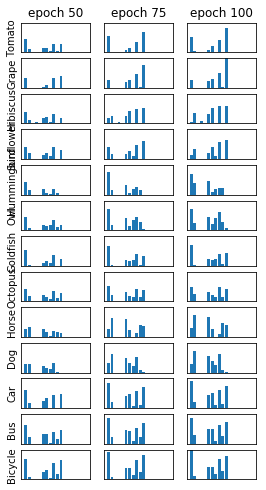

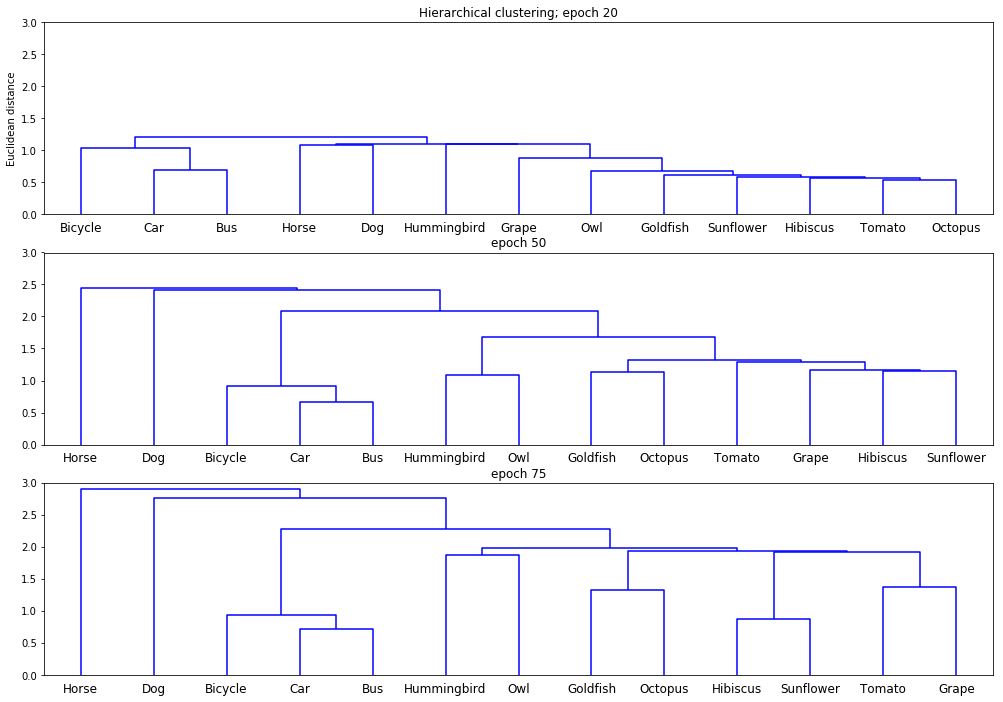

In [30]:
plot_rep(rep4,rep1,rep2,names_items)
plot_dendo(rep4,rep1,rep2,names_items)